# Lotka-Volterra predatory-prey model

In this example we'll consider the Lotka-Volterra predator-prey model using Variational Bayesian inference. The data, is given in the below cell together with a visualization.

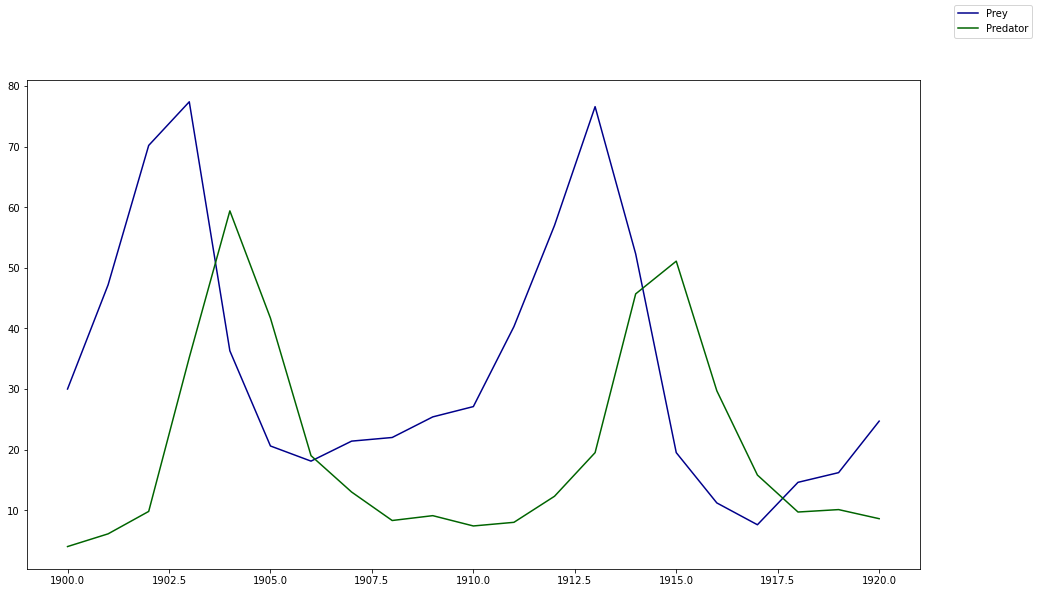

In [1]:
import matplotlib.pyplot as plt
import numpy as np

lynx = np.array([4.0, 6.1, 9.8, 35.2, 59.4, 41.7, 19.0, 13.0, 8.3, 9.1, 7.4,
                8.0, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6])
hare = np.array([30.0, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22.0, 25.4,
                 27.1, 40.3, 57.0, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7])

data = np.hstack((hare[:, None], lynx[:, None]))

fig, ax = plt.subplots(figsize=(16, 9))

years = np.arange(1900, 1921, 1)

hare_color = "darkblue"
lynx_color = "darkgreen"

ax.plot(years, hare, color=hare_color, label="Prey")
ax.plot(years, lynx, color=lynx_color, label="Predator")

fig.legend()

The model is given by the following differential equation

\begin{align}
    \dot{x} & = \alpha x - \beta xy, \\
    \dot{y} & = -\gamma y + \delta xy, \\
\end{align}

where $\alpha, \beta, \gamma, \delta > 0$. We'll proceed as in [lorenz.ipynb](./lorenz.ipynb) and recast the model into a stochastic process. 

This time around we do not have any values for the parameters, and we're thus interested in estimating these. A part from this, we'll also make the problem a tad bit more complicated by assuming that the values we're observing are sampled every 5th step, such that we'll try to interpolate the solution.

Furthermore, we also assume that we observe the solution corrupted by noise, s.t. we get the following observable model

\begin{align}
    Z_t^x & = X_t + V^x_t, \\
    Z_t^y & = Y_t + V^y_t, \\
    t &\in \mathbb{N}
\end{align}

where we assume that $V^i_t \sim \mathcal{N}(0, 0.25)$. The assumption of using Gaussian random variables is somewhat erronous as this technically allows the observations to be negative, but as this is just an example we'll go along with it.

Next, define the model.

In [2]:
import pyro
from pyro.distributions import Exponential, LogNormal, Normal
from stochproc.timeseries import RungeKutta, StateSpaceModel
from tqdm import tqdm
import torch
from stochproc import __version__

print(f"stoch-proc version: {__version__}")


def f(x, alpha, beta, gamma, delta):
    xt, yt = x.value[..., 0], x.value[..., 1]

    cross_prod = xt * yt
    f_x = xt * alpha - beta * cross_prod
    f_y = -yt * gamma + delta * cross_prod
    
    return torch.stack((f_x, f_y), dim=-1)


def obs_dist(x, s):
    return Normal(loc=x.value, scale=s).to_event(1)


observe_every = 5


def lotka_volterra_prob(data):
    dt = 0.2    
    tau = 1e-1
    
    alpha = pyro.sample("alpha", Exponential(rate=1.0))
    beta = pyro.sample("beta", Exponential(rate=5.0))
    gamma = pyro.sample("gamma", Exponential(rate=1.0))
    delta = pyro.sample("delta", Exponential(rate=5.0))

    initial_values = pyro.sample(
        "init_values", LogNormal(loc=data[0].log(), scale=0.75).to_event(1)
    )

    lotka_volterra = RungeKutta(
        f, (alpha, beta, gamma, delta), initial_values, dt=dt, tuning_std=tau, event_dim=1
    )

    scale = 0.25 * torch.ones(2)
    ssm = StateSpaceModel(lotka_volterra, obs_dist, parameters=(scale,), observe_every_step=observe_every)

    ssm.do_sample_pyro(pyro, t_final=data.shape[0], obs=data)


stoch-proc version: 0.0.8


And then infer the parameters

In [3]:
y = torch.from_numpy(data).float()
    
guide = pyro.infer.autoguide.AutoDiagonalNormal(lotka_volterra_prob)
optim = pyro.optim.Adam({"lr": 1e-2})
svi = pyro.infer.SVI(lotka_volterra_prob, guide, optim, loss=pyro.infer.Trace_ELBO())

niter = 50_000
pyro.clear_param_store()

running_average = 0.0
smoothing = 0.99

bar = tqdm(range(niter))
for n in bar:
    loss = svi.step(y)
    
    running_average = smoothing * running_average + (1 - smoothing) * loss
    bar.set_description(f"Loss: {running_average:,.2f}")

Loss: 10,426.15: 100%|██████████████████████████████████████████████████████████| 50000/50000 [07:59<00:00, 104.20it/s]


Next, plot the parameter posteriors.

array([<AxesSubplot:title={'center':'alpha\n0'}>,
       <AxesSubplot:title={'center':'beta\n0'}>,
       <AxesSubplot:title={'center':'gamma\n0'}>,
       <AxesSubplot:title={'center':'delta\n0'}>], dtype=object)

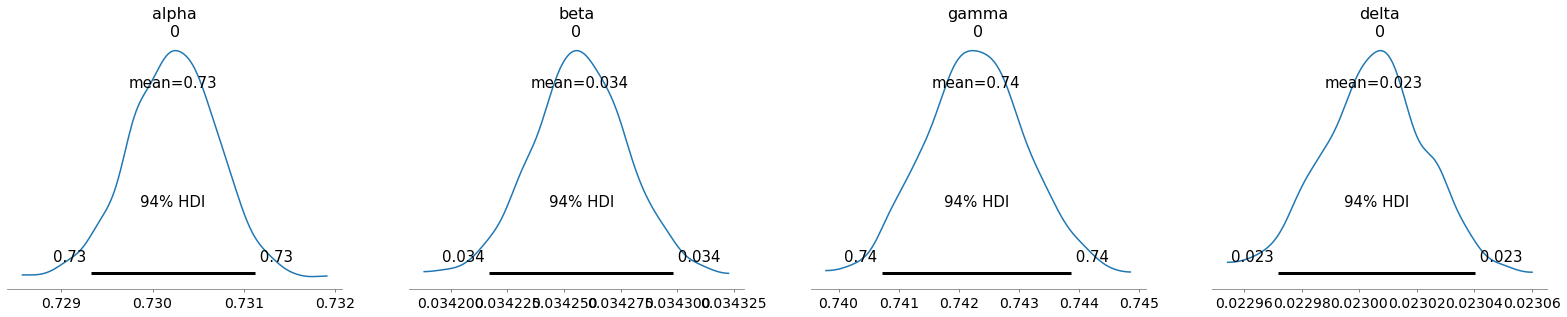

In [4]:
import arviz
import pandas as pd

num_samples = 1_000
posterior_predictive = pyro.infer.Predictive(
    lotka_volterra_prob,
    guide=guide,
    num_samples=num_samples
)

posterior_draws = {k: v.unsqueeze(0) for k, v in posterior_predictive(y).items()}

posteriors = arviz.from_dict(posterior_draws)
arviz.plot_posterior(posteriors, var_names=["alpha", "beta", "gamma", "delta"])

And also plot the inferred states.

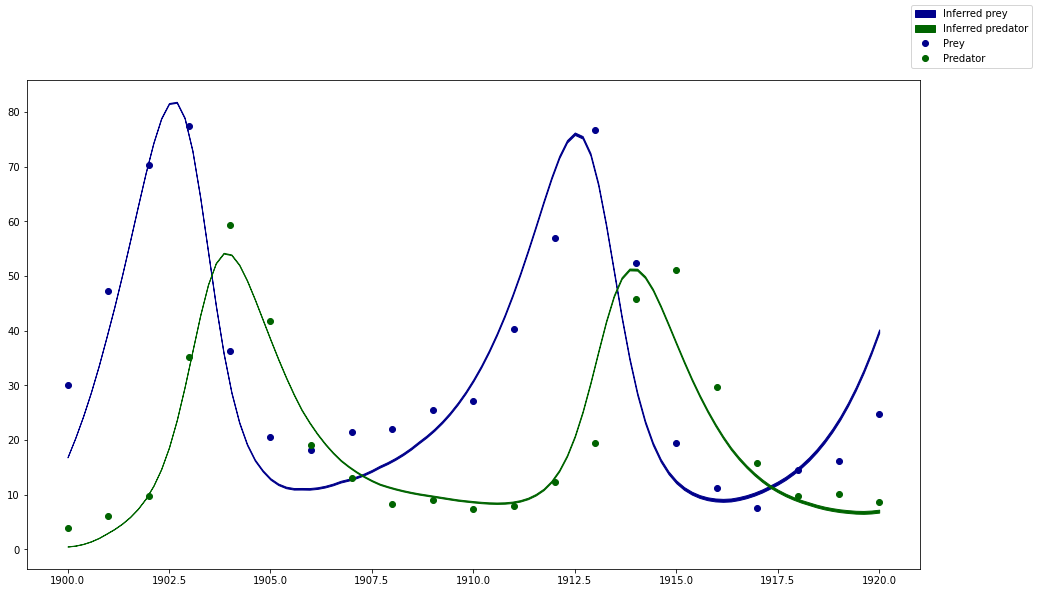

In [5]:
fig, ax = plt.subplots(figsize=(16, 9))

squeezed = posterior_draws["auxiliary"].squeeze(0)

mean = squeezed.mean(dim=0)
std = squeezed.std(dim=0)

low = mean - std
high = mean + std

xrange = np.linspace(years[0], years[-1], num=low.shape[0] - 1)

ax.fill_between(xrange, low[1:, 0], high[1:, 0], color=hare_color, label="Inferred prey")
ax.fill_between(xrange, low[1:, 1], high[1:, 1], color=lynx_color, label="Inferred predator")

ax.plot(years, hare, "o", color=hare_color, label="Prey")
ax.plot(years, lynx, "o", color=lynx_color,  label="Predator")

fig.legend()